In [ ]:
import Pkg
Pkg.add("Distributions")
Pkg.add("StatsPlots")
Pkg.add("SpecialFunctions")
Pkg.add("QuadGK")
using Random, Distributions, StatsPlots, SpecialFunctions, QuadGK

In [ ]:
function compensator(time::Number, events::Array{<:Number}, mu::Number, kern::Function)
    if minimum(events) >= time
        return mu
    else
        return mu + sum(kern, time .- events[events .< time])
    end
end

In [ ]:
function counter(time::Number, events::Array{<:Number})
    n = 0
    if minimum(events) >= time
        return 0
    else
        for k = 1:length(events)
            if events[k] < time
                n += 1
            end
        end
        return n
    end
end

In [ ]:
function phi(x, alpha::Number)
constant = 2*alpha/((alpha+1)*(alpha+2))
    if x < 1
        return -constant * (alpha+1) * x + constant * (alpha+2)
    elseif x >= 1
        return constant * x^(-(1+alpha))
    end
end

In [ ]:
function RHL(f::Function,a::Number,err::Number)
    h = 0000000.1
    u = abs(f(a+h)-f(a+h/10))
    k = 1
    while u >= err
        u = abs(f(a+h/10^k)-f(a+h/10^(k+1)))
        k += 1
    end
    return f(a+h/10^(k+1))
end

In [ ]:
function spInt(f::Function, discs::Array{<:Number}, x::Number)
    ans = 0
    if x < minimum(discs)
        ans = quadgk(u->f(u),0,x)[1]
    elseif x >= minimum(discs)
        former = discs[discs .< x]
        l = length(former)
        ans = ans + quadgk(u -> f(u),0,former[1])[1]
        if l >= 2
            for i in 2:l
                ans = ans + quadgk(u -> f(u),former[i-1],former[i])[1]
            end
        end
        ans = ans + quadgk(u -> f(u),former[l],x)[1]
    end
    return ans
end

In [ ]:
function newTime(s::Number, lambda::Number)
    U = rand(Uniform())
    s = s-log(U)/lambda
    return s
end

In [ ]:
function sim()
    
#Initializing Constants
    TH = 10                         #Time Horizon
    alpha = 0.5                        #Our Hurst parameter + .5
    #K = 2*alpha/((alpha+1)*(alpha+2))  #Assumption 1/2 Constants
    #delta = K*gamma(1-alpha)/alpha     #
    #lamstar = 1                        #
    #mustar = 1                         #
    mu = .9                           #Background Intensity mustar/(delta*(TH)^(1-alpha))
    aT = .9                           #Constants for each Time Horizon 1-lamstar*delta/(TH)^(alpha)
    tint = mu                          #Test Intensity Initialization for Thinning
    l = 1                              #
    Points = Float64[0]                #Catches the Points of the Process
    limErr = 10^(-32)                  #Error Tolerance for Limit Function
    dt = 1/100


#Creating Functions
    kernel(x) = aT*phi(x,alpha)
    lambda(x) = compensator(x,Points,mu,kernel)
    PProcess(x) = counter(x,Points)


#First Event
    s = newTime(0,tint)
    Points[1] = s
    l = length(Points)
    tint = lambda(RHL(lambda,Points[l],limErr))

#Future Events
    while s < TH
    
    #New Event
        s = newTime(s,tint)
        if s >= TH
            break
        end

    #Rejection by Thinning
        D = rand(Uniform())
        if D <= lambda(s)/tint
            append!(Points,s)
            l = length(Points)
            tint = lambda(RHL(lambda,Points[l],limErr))
        else
            tint = lambda(s) ##Fix this?
        end

    end


#Results of Hawkes Process wrt TH
    p1 = plot(lambda, 0, TH)
    p2 = plot(PProcess, 0, TH)
    plot(p1,p2, layout = (2,1))

#    intensityIntegral(x) = quadgk(u -> lambda(u), 0, x)[1]
    integ(x) = spInt(lambda,Points,x)
    martingale(x) = PProcess(x)-integ(x)
    p3 = plot(martingale,0,TH)
    plot(p1,p2,p3, layout = (3,1))


#Attempthing to make a BM
    M = convert(Int,floor(TH/dt))
    martVec = zeros(M+1)
    lamVec = zeros(M+1)
    diffVec = zeros(M)
    N = 0
    while N <= M
        martVec[N+1] = martingale(N*dt)
        lamVec[N+1] = lambda(N*dt) 
        if N >= 1
            diffVec[N] = martVec[N+1] - martVec[N]
        end
        N += 1
    end
    newlamVec = view(lamVec,1:M)
    partSum = zeros(M)
    for ii in 1:M
        partSum[ii] = (1/sqrt(TH))*diffVec[ii]/(sqrt(newlamVec[ii]))
    end
    cumSum = accumulate(+,partSum)
    BMVec = pushfirst!(cumSum,0)
    plot(p1,p2,p3, layout = (3,1))
end

  0.811693 seconds (9.20 M allocations: 554.587 MiB, 13.64% gc time)


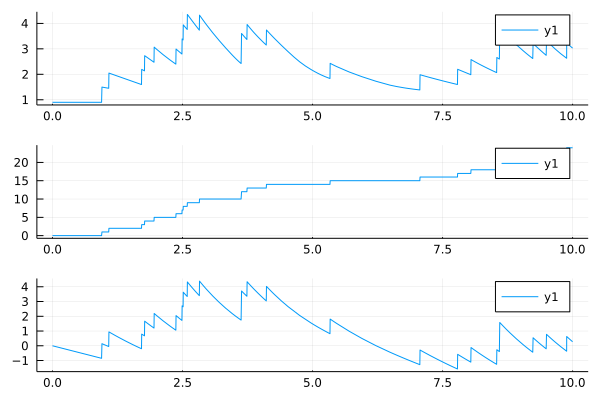

In [316]:
@time begin
sim()
end

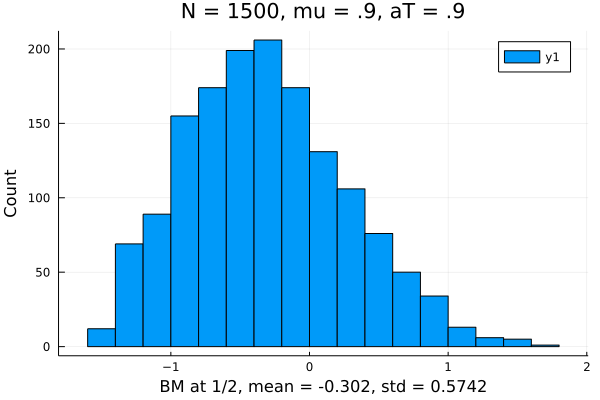

598.251200 seconds (8.87 G allocations: 468.073 GiB, 11.71% gc time)


In [313]:
@time begin
N = 1500
a = string(N,base = 10, pad = 4)
data = zeros(N)
for k in 1:N
    data[k] = sim()[501]
end
m = round(mean(data),digits=4)
s = round(std(data; corrected = false),digits=4)
mm = string(m)
ss = string(s)
gr()
q = Plots.plot(histogram(
    data,
    title = "N = "*a*", mu = .9, aT = .9",
    xlabel = "BM at 1/2, mean = "*mm*", std = "*ss,
    ylabel = "Count"))
savefig(q,"TH10Case8Test3")
Plots.display(q)
end

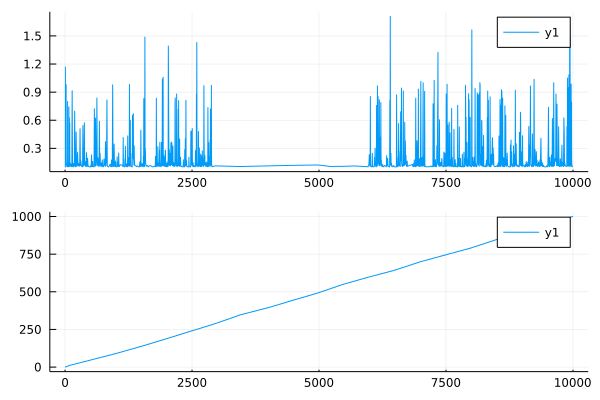

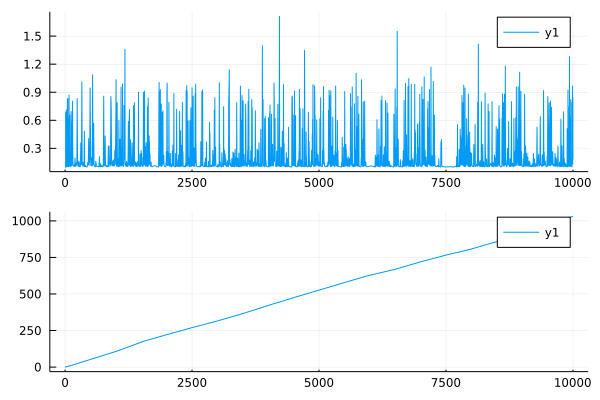

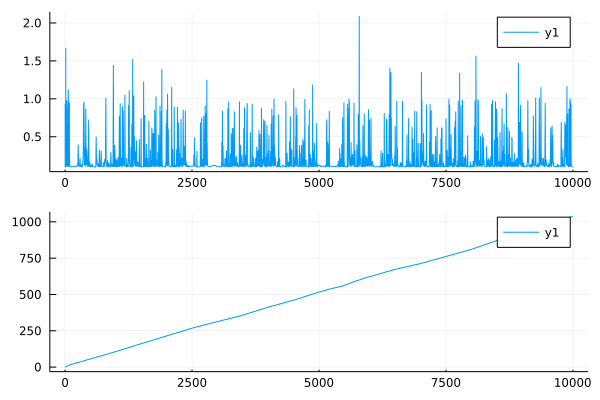

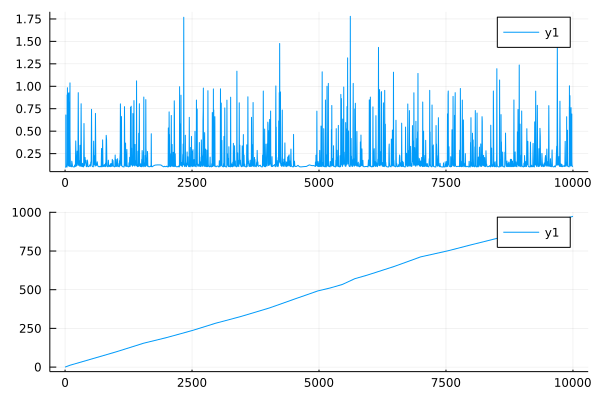

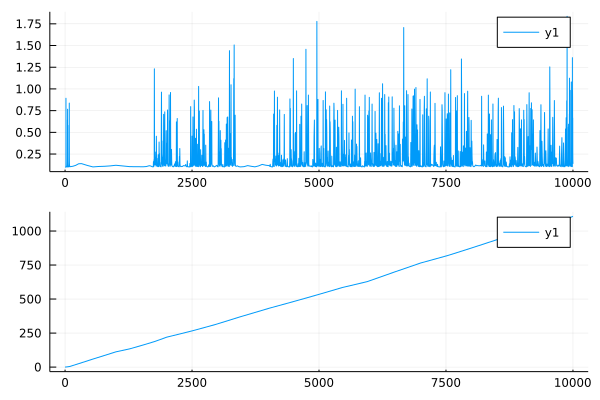

In [125]:
M = 5
for i in 1:M
    a = string(i,base = 10,pad = 4)
    q = Plots.plot(sim())
    #savefig(q,a*"H=50")
    Plots.display(q)
end


In [81]:
std([1,2,3,4]; corrected = false)

1.2500000000000002